In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn import set_config; set_config(display='diagram')
import pickle
import matplotlib.pyplot as plt

In [2]:
#load data
df = pd.read_pickle(f'../models/all_df.pickle')

#reset row index
df.reset_index(drop=True, inplace=True)
df = df.sort_values('date')
df

,store_nbr,date,sales,onpromotion,city,state,type_stores,cluster,type_holiday,locale,locale_name,oil_price,oil_price_interpolated,transactions
37217,25,2013-01-01,2511.618999,0,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,0.00,0.00,770.0
0,1,2013-01-02,7417.148000,0,Quito,Pichincha,D,13,Not Holiday,Not Holiday,Not Holiday,93.14,93.14,2111.0
33963,23,2013-01-02,6560.337000,0,Ambato,Tungurahua,D,9,Not Holiday,Not Holiday,Not Holiday,93.14,93.14,1381.0
35640,24,2013-01-02,11018.852996,0,Guayaquil,Guayas,D,1,Not Holiday,Not Holiday,Not Holiday,93.14,93.14,2605.0
37218,25,2013-01-02,5316.224000,0,Salinas,Santa Elena,D,1,Not Holiday,Not Holiday,Not Holiday,93.14,93.14,1038.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73818,47,2017-08-15,31653.691000,178,Quito,Pichincha,A,14,Holiday,Local,Riobamba,47.57,47.57,3581.0
25041,15,2017-08-15,7946.431000,245,Ibarra,Imbabura,C,15,Holiday,Local,Riobamba,47.57,47.57,1320.0
23365,14,2017-08-15,9342.732000,215,Riobamba,Chimborazo,C,7,Holiday,Local,Riobamba,47.57,47.57,1241.0
72141,46,2017-08-15,22348.414970,163,Quito,Pichincha,A,14,Holiday,Local,Riobamba,47.57,47.57,3197.0


In [3]:
# Define the features to encode
features_to_encode = ['type_holiday', 'locale', 'locale_name']

# Create an instance of OrdinalEncoder
encoder = OrdinalEncoder()

# Fit and transform the specified features in the DataFrame
df[features_to_encode] = encoder.fit_transform(df[features_to_encode])

In [4]:
df

,store_nbr,date,sales,onpromotion,city,state,type_stores,cluster,type_holiday,locale,locale_name,oil_price,oil_price_interpolated,transactions
37217,25,2013-01-01,2511.618999,0,Salinas,Santa Elena,D,1,8.0,4.0,5.0,0.00,0.00,770.0
0,1,2013-01-02,7417.148000,0,Quito,Pichincha,D,13,10.0,5.0,21.0,93.14,93.14,2111.0
33963,23,2013-01-02,6560.337000,0,Ambato,Tungurahua,D,9,10.0,5.0,21.0,93.14,93.14,1381.0
35640,24,2013-01-02,11018.852996,0,Guayaquil,Guayas,D,1,10.0,5.0,21.0,93.14,93.14,2605.0
37218,25,2013-01-02,5316.224000,0,Salinas,Santa Elena,D,1,10.0,5.0,21.0,93.14,93.14,1038.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73818,47,2017-08-15,31653.691000,178,Quito,Pichincha,A,14,8.0,0.0,25.0,47.57,47.57,3581.0
25041,15,2017-08-15,7946.431000,245,Ibarra,Imbabura,C,15,8.0,0.0,25.0,47.57,47.57,1320.0
23365,14,2017-08-15,9342.732000,215,Riobamba,Chimborazo,C,7,8.0,0.0,25.0,47.57,47.57,1241.0
72141,46,2017-08-15,22348.414970,163,Quito,Pichincha,A,14,8.0,0.0,25.0,47.57,47.57,3197.0


In [5]:
# group the DataFrame by date and sum the sales and average the oil_price for each date
sales_by_date = df.groupby('date').agg({'sales': 'sum', 
                                        'oil_price': 'mean', 
                                        'onpromotion': 'mean',
                                        'type_holiday': 'mean',
                                        'locale': 'mean',
                                        'locale_name': 'mean'}).reset_index()

# create a new DataFrame with only the 'date', 'sales', and 'oil_price' columns
df_filtered = sales_by_date[['date', 'sales', 'oil_price', 'onpromotion', 'type_holiday', 'locale', 'locale_name']]


In [6]:
df_filtered

,date,sales,oil_price,onpromotion,type_holiday,locale,locale_name
0,2013-01-01,2511.618999,0.00,0.000000,8.0,4.0,5.0
1,2013-01-02,496092.417944,93.14,0.000000,10.0,5.0,21.0
2,2013-01-03,361461.231124,92.97,0.000000,10.0,5.0,21.0
3,2013-01-04,354459.677093,93.12,0.000000,10.0,5.0,21.0
4,2013-01-05,477350.121229,0.00,0.000000,12.0,4.0,5.0
...,...,...,...,...,...,...,...
1677,2017-08-11,826373.722022,48.81,262.574074,11.0,4.0,5.0
1678,2017-08-12,792630.535079,0.00,153.925926,10.0,5.0,21.0
1679,2017-08-13,865639.677471,0.00,171.907407,10.0,5.0,21.0
1680,2017-08-14,760922.406081,47.59,148.944444,10.0,5.0,21.0


In [7]:
data = df_filtered.set_index('date')
data = data.resample('D').sum()
data = data.dropna()
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [8]:
data_scaled.shape

(1688, 6)

In [9]:
# Split the data into training and test sets
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

In [10]:
# Define the input and output data
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back), :])
        Y.append(data[(i+look_back), 0])
    return np.array(X), np.array(Y)

In [11]:

look_back = 7  # number of past time steps to use as input
train_X, train_Y = create_dataset(train_data, look_back)
test_X, test_Y = create_dataset(test_data, look_back)


In [12]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(look_back, 6)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dropout(0.2))
model.add(Dense(units=1))


In [13]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [14]:
# Train the model
model.fit(train_X, train_Y, epochs=100, batch_size=64)


Epoch 1/100


2023-04-24 14:09:19.027556: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


21/21 [==============================] - 3s 9ms/step - loss: 0.0114
Epoch 2/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0055
Epoch 3/100
21/21 [==============================] - 0s 11ms/step - loss: 0.0046
Epoch 4/100
21/21 [==============================] - 0s 11ms/step - loss: 0.0042
Epoch 5/100
21/21 [==============================] - 0s 11ms/step - loss: 0.0041
Epoch 6/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0039
Epoch 7/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0036
Epoch 8/100
21/21 [==============================] - 0s 14ms/step - loss: 0.0036
Epoch 9/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0036
Epoch 10/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0037
Epoch 11/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0034
Epoch 12/100
21/21 [==============================] - 0s 11ms/step - loss: 0.0035
Epoch 13/100
21/21 [==================

In [15]:
# Make predictions on the test data
test_predictions = model.predict(test_X)

11/11 [==============================] - 1s 2ms/step


In [16]:
test_predictions

array([[0.24384242],
       [0.22195256],
       [0.20568828],
       [0.21366748],
       [0.23052296],
       [0.31585371],
       [0.30909443],
       [0.23510112],
       [0.21378002],
       [0.19729014],
       [0.20661919],
       [0.22215582],
       [0.29721597],
       [0.29024643],
       [0.22995746],
       [0.21345434],
       [0.20378053],
       [0.21899995],
       [0.2454939 ],
       [0.33605868],
       [0.32819688],
       [0.24800617],
       [0.2245796 ],
       [0.20957056],
       [0.21841614],
       [0.23666662],
       [0.3309869 ],
       [0.31666446],
       [0.2335685 ],
       [0.21277589],
       [0.20046097],
       [0.20758525],
       [0.22502741],
       [0.31648266],
       [0.31192344],
       [0.23298562],
       [0.21224228],
       [0.19833413],
       [0.21072148],
       [0.23259403],
       [0.33656722],
       [0.32607692],
       [0.23686591],
       [0.21122617],
       [0.19074906],
       [0.20613421],
       [0.22803104],
       [0.338

In [17]:
# Evaluate the model performance on the test data
test_mae = tf.keras.losses.mean_absolute_error(test_Y, test_predictions).numpy()
test_mse = tf.keras.losses.mean_squared_error(test_Y, test_predictions).numpy()
print("Test MAE: ", test_mae)
print("Test MSE: ", test_mse)


Test MAE:  [0.04928187 0.05499146 0.06514012 0.05983463 0.05135306 0.07502428
 0.0711453  0.05011536 0.0597637  0.07148416 0.06449712 0.05488574
 0.06484634 0.06161655 0.0515344  0.0599701  0.0664902  0.0565965
 0.04931734 0.08839612 0.08293563 0.04943291 0.05368402 0.06250246
 0.05693609 0.04981447 0.08485472 0.07551499 0.05046194 0.06040617
 0.06899262 0.06383552 0.0534734  0.07540481 0.07272524 0.05062261
 0.06075222 0.07064956 0.06174045 0.05073179 0.08876564 0.08151903
 0.04978174 0.06141114 0.07698282 0.0648295  0.05221066 0.09040466
 0.06782178 0.05404131 0.06893068 0.08323118 0.06741584 0.05496788
 0.06781194 0.06724428 0.04929816 0.05686012 0.07370178 0.06976701
 0.0609576  0.07484392 0.07237148 0.0501924  0.06025747 0.06761337
 0.05606228 0.04927837 0.09489737 0.07351673 0.05309514 0.06313013
 0.06714262 0.04962775 0.05452832 0.08717226 0.07256806 0.05076976
 0.05540192 0.06502794 0.05924043 0.05426808 0.06382634 0.05428473
 0.06082716 0.06447425 0.07803515 0.06355584 0.05394

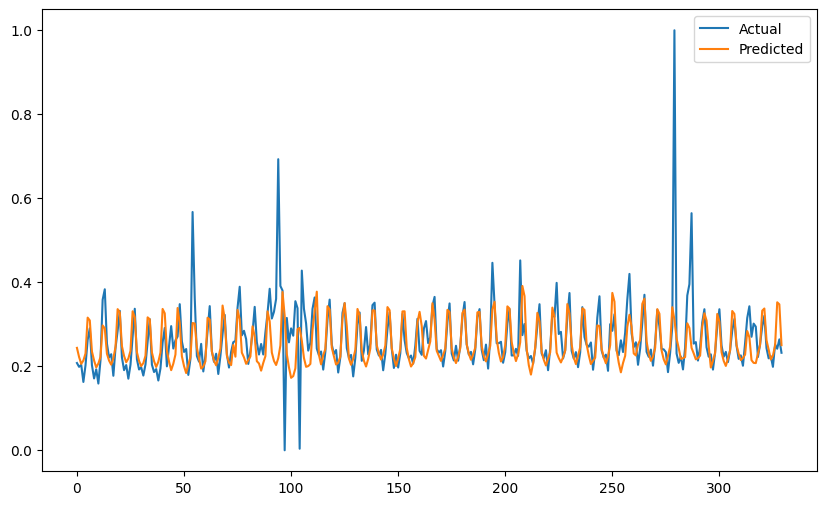

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(test_Y, label='Actual')
plt.plot(test_predictions, label='Predicted')
plt.legend()
plt.show()

In [19]:

mse = mean_squared_error(test_Y, test_predictions)
mae = mean_absolute_error(test_Y, test_predictions)

print("MSE: ", mse)
print("MAE: ", mae)

MSE:  0.005315822857000887
MAE:  0.039596493435997984
